# Run each scheme

Using this Notebook to test the module, so using IPy extension `autoreload`. 

Test the following:
* running 
* plot methods for model class
* output xr
* plots for model class
* plots for output xr

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# mpl notebook mode doesn't work in Lab
%matplotlib notebook
#%matplotlib inline

In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import crt1d as crt

## Run (just once)
Run the default case (which is loaded automatically when model object is created).

In [4]:
schemes_to_test = ['bl', 'bf', 'gd', '2s', 'zq', '4s']
#schemes_to_test = ['2s']
#schemes_to_test = ['bl', '2s', '4s', 'zq']
#schemes_to_test = ['bl', '2s', '4s', 'bf']
#schemes_to_test = ['2s', '4s']

ms = []
for scheme_ID in schemes_to_test:
    m = crt.model(scheme_ID, nlayers=60)
    #m.plot_canopy()
    m.run()
    ms.append(m)
    
dsets = [m.to_xr() for m in ms]

../crt1d/crt1d.py:223: UserWarning: wl for optical props and toc BC appear to be incompatible
  warnings.warn('wl for optical props and toc BC appear to be incompatible')
/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


### Examine default case

Leaf area profile and leaf angle dist

<IPython.core.display.Javascript object>


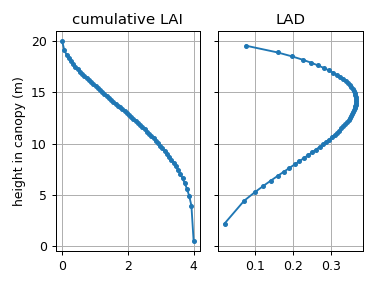

In [5]:
ms[0].plot_canopy()

## Plots of results

<IPython.core.display.Javascript object>


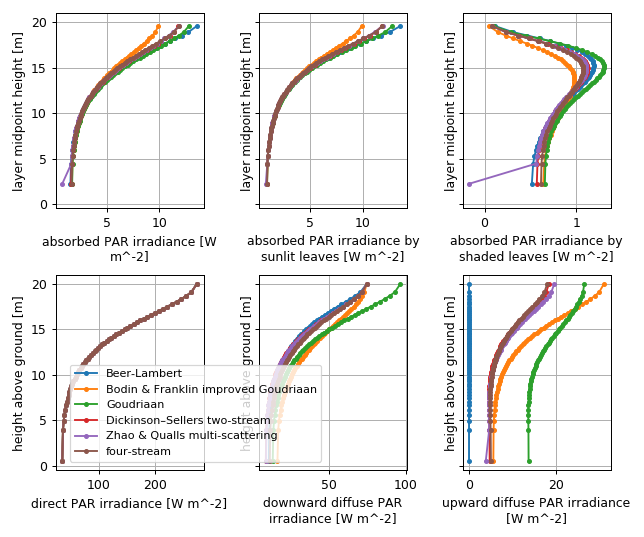

In [6]:
crt.crt1d.plot_PAR(dsets)

<IPython.core.display.Javascript object>


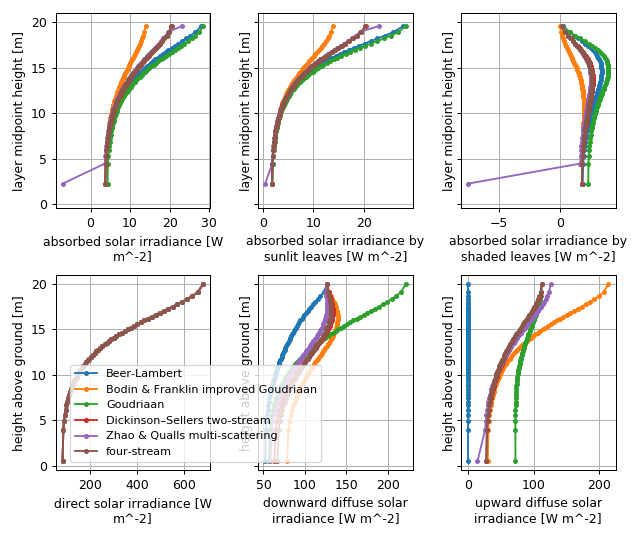

In [7]:
crt.crt1d.plot_solar(dsets)

### Other diagnostic tools

In [8]:
df = crt.crt1d.create_E_closure_table(dsets)
df.astype(float).round(2)

,incoming,outgoing (reflected),soil absorbed,layerwise abs sum,in-out-soil,canopy abs
bl,807.14,0.00,136.74,670.39,670.39,670.39
bf,807.14,213.83,132.81,460.50,460.50,460.50
gd,901.94,112.83,68.99,720.12,720.12,720.12
2s,807.14,112.52,119.83,574.78,574.78,574.78
zq,807.14,126.18,128.30,552.66,552.66,552.66
4s,807.14,112.69,123.12,571.34,571.34,571.34


In [9]:
m.crs.keys()

dict_keys(['I_dr0_all', 'I_df0_all', 'wl', 'dwl', 'psi', 'mu', 'G', 'K_b', 'I_dr', 'I_df_d', 'I_df_u', 'F'])

## Datasets and their variables

In [10]:
dsets[0]

<xarray.Dataset>
Dimensions:           (wl: 108, z: 60, zm: 59)
Coordinates:
  * z                 (z) float64 0.5 3.966 4.922 5.609 ... 18.68 19.11 20.0
  * wl                (wl) float64 0.3 0.305 0.31 0.315 ... 2.36 2.45 2.5 2.6
  * zm                (zm) float64 2.233 4.444 5.266 5.888 ... 18.51 18.89 19.55
Data variables:
    I_dr              (z, wl) float64 0.000642 0.00611 ... 0.5482 2.801e-07
    I_df_d            (z, wl) float64 0.000704 0.006052 ... 0.02374 1.198e-08
    I_df_u            (z, wl) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    F                 (z, wl) float64 0.002091 0.01861 ... 0.6309 3.22e-07
    I_d               (z, wl) float64 0.001346 0.01216 ... 0.572 2.921e-07
    dwl               (wl) float64 0.005 0.005 0.005 0.005 ... 0.09 0.05 0.1 0.1
    lai               (z) float64 4.0 3.932 3.864 3.797 ... 0.1356 0.0678 0.0
    dlai              (zm) float64 0.0678 0.0678 0.0678 ... 0.0678 0.0678 0.0678
    aI                (zm, wl) float64 5.078e-05 

In [11]:
dsets[0]['zm']

<xarray.DataArray 'zm' (zm: 59)>
array([ 2.233243,  4.444249,  5.265545,  5.888072,  6.406822,  6.859524,
        7.265752,  7.637189,  7.981456,  8.303839,  8.608181,  8.897375,
        9.173663,  9.438827,  9.694307,  9.94129 , 10.180769, 10.413585,
       10.640457, 10.862012, 11.078795, 11.29129 , 11.499927, 11.705094,
       11.907143, 12.106395, 12.303146, 12.497673, 12.690234, 12.881074,
       13.070427, 13.258519, 13.445569, 13.631793, 13.817406, 14.002623,
       14.187664, 14.372752, 14.558122, 14.744021, 14.93071 , 15.118471,
       15.307616, 15.498485, 15.691464, 15.886992, 16.085578, 16.287821,
       16.494442, 16.706323, 16.924573, 17.150628, 17.386407, 17.6346  ,
       17.899194, 18.186622, 18.508678, 18.892952, 19.552798])
Coordinates:
  * zm       (zm) float64 2.233 4.444 5.266 5.888 ... 18.19 18.51 18.89 19.55
Attributes:
    units:      m
    long_name:  layer midpoint height

In [12]:
m.extra_solver_results.keys()

dict_keys([])